In [147]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras
from noise_generator.noisegen import NoiseHandling
import time

In [148]:
%load_ext autoreload
%autoreload 2
from audio_process.fft import expand_image_dims, train_img_generate
from Image_Generator_helpers import get_item, DataSets, set_paths, global_path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
model_velocity = keras.models.load_model('saved_model_velocity')
model_regression = keras.models.load_model('saved_model_regression')
model_categorical = keras.models.load_model('saved_model_categorical_right_align')
TRAINING_IMAGE_DIMENSIONS = (5, 1400)
NODGE_IMAGE_PIXEL_AMOUNT = 5 #Push the image to the left to adjust for incorrect position prediction
CATEGORICAL_IMAGE_CROPPED_WIDTH = TRAINING_IMAGE_DIMENSIONS[1] - 1250 #Cropped with during traing of categorical prediction model"
FFT_JUMP = 64
MEAN_TEMPO_OF_TRAINING_DATA = (18 + 25) / 2 # The mean tempo of the training data tempis 

In [150]:
def show_image(img, start=0, width=300):
    plt.figure(figsize=(30,5))
    plt.xlim(start, width)
    plt.imshow(img)
    plt.show()

# insert an image into an empty image at start and en position
def insert_image(empty_image, image, start_pos, end_pos):
    empty_image[:, start_pos:end_pos] = image
    return empty_image

In [151]:
Cnoise=NoiseHandling()
Cnoise.SetFrequencies(6000,2200,200)
Cnoise.noise_rng
# From 0 = no noise to -15 = significant noise
# INFO:  table of SNRdb vs. digit in version\n",
# ver \t 0   1   2  3  4\n",
# SNRdB   30  10  5  2  0\n",

<bound method NoiseHandling.noise_rng of <noise_generator.noisegen.NoiseHandling object at 0x7f2824199b50>>

Add noise to image

--- 1.646456241607666 seconds ---
Word nr : 0
qjlvujolkvyzh
First image:


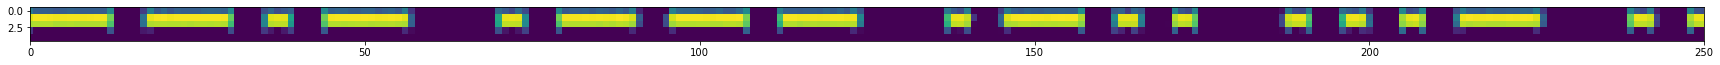

[[0.41570395 0.30258068 0.30000013 ... 0.         0.         0.        ]
 [0.95089453 0.98679864 0.98608524 ... 0.         0.         0.        ]
 [0.86875755 0.88158083 0.88959062 ... 0.         0.         0.        ]
 [0.15673408 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Word nr : 1
xxuhnpzyukxkllc
First image:


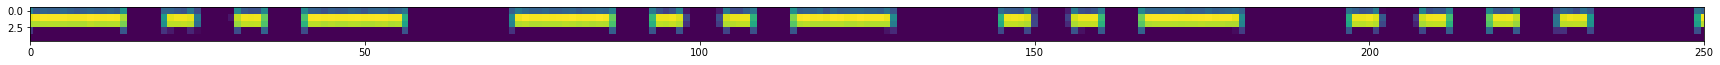

[[0.44993344 0.28888083 0.32648173 ... 0.         0.         0.        ]
 [0.95822334 0.98268139 0.99341744 ... 0.         0.         0.        ]
 [0.87298548 0.88109332 0.88884127 ... 0.         0.         0.        ]
 [0.15925828 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Word nr : 2
aictfjrj
First image:


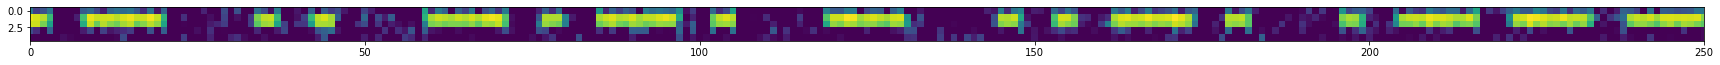

[[0.39468765 0.18543729 0.25097948 ... 0.         0.         0.        ]
 [0.96873188 0.9404217  0.88866663 ... 0.         0.         0.        ]
 [0.92759788 0.9242813  0.79518282 ... 0.         0.         0.        ]
 [0.23811512 0.12682171 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Word nr : 3
urjuxn
First image:


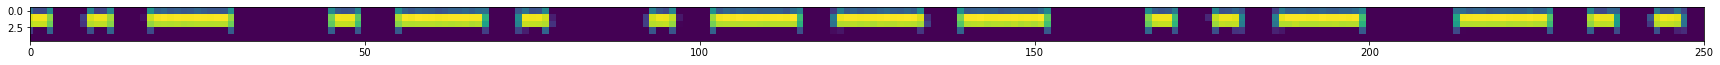

[[0.3751007  0.22445516 0.21929221 ... 0.         0.         0.        ]
 [0.94607699 0.97873461 0.97771341 ... 0.         0.         0.        ]
 [0.89181674 0.91443378 0.91706067 ... 0.         0.         0.        ]
 [0.16919918 0.00680618 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Word nr : 4
gqgi
First image:


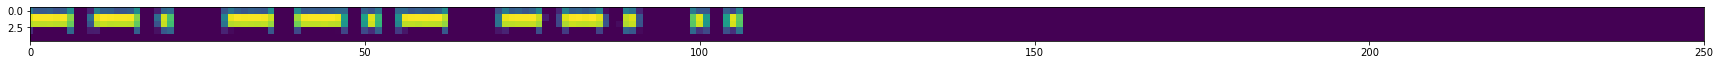

[[0.41639414 0.27677694 0.28902593 ... 0.         0.         0.        ]
 [0.95681095 0.98920572 0.99052703 ... 0.         0.         0.        ]
 [0.88503838 0.90761644 0.90214694 ... 0.         0.         0.        ]
 [0.12501307 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Word nr : 5
g
First image:


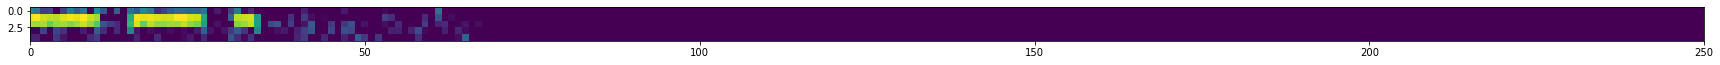

[[0.47841635 0.39573509 0.180933   ... 0.         0.         0.        ]
 [0.96575612 0.99354827 0.92711878 ... 0.         0.         0.        ]
 [0.87892741 0.85894501 0.87271768 ... 0.         0.         0.        ]
 [0.         0.         0.19746752 ... 0.         0.         0.        ]
 [0.07495127 0.09161615 0.         ... 0.         0.         0.        ]]
Word nr : 6
gudgml
First image:


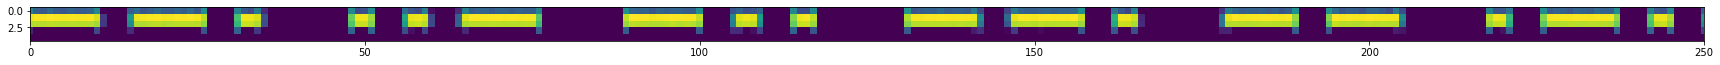

[[0.45511055 0.30173007 0.2756823  ... 0.         0.         0.        ]
 [0.96869433 0.99045992 0.98472035 ... 0.         0.         0.        ]
 [0.88652956 0.8894437  0.89142978 ... 0.         0.         0.        ]
 [0.10472937 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [152]:
set_obj = DataSets(set_paths, global_path)

def apply_noise(signal):
    signal_to_noise_ratio_db = 30
    signal_noise, some_noise = Cnoise.addNoise(signal, signal_to_noise_ratio_db)
    return signal_noise

start_time = time.time()

random_sets = [set_obj.get_random() for n in range(128)]
random_signals = [get_item(random_set) for random_set in random_sets]
signals_shiftet = [np.insert(signal, 0, np.zeros(0), axis=0) for signal in random_signals] ## prepend with 12840 zeros to align with image pixel 200
signal_noises = [apply_noise(signal) for signal in signals_shiftet]
images_noise = [train_img_generate(signal_noise, FFT_JUMP) for signal_noise in signal_noises]

print("--- %s seconds ---" % (time.time() - start_time))

set_obj.close_files()

for idx,img in enumerate(images_noise):
    print(f"Word nr : {idx}")
    print(random_sets[idx].csv_row.WORD)
    print("First image:")
    show_image(img, 0, 250)
    print(img)
    if (idx > 5):
        break
   

Velocity prediction

In [153]:
velocity_prediction = (model_velocity(expand_image_dims(images_noise[0]))).numpy()[0][0] * 100
velocity_prediction

21.980878710746765

Generate new image with mean tempo of training data based on velocity prediction

In [154]:
fft_jump_tempo_coefficient = (MEAN_TEMPO_OF_TRAINING_DATA / velocity_prediction)
rescaled_jump = FFT_JUMP * fft_jump_tempo_coefficient
img_noise_rescaled = train_img_generate(signal_noises[0], rescaled_jump)

Check n-px ahead and determine signal activity

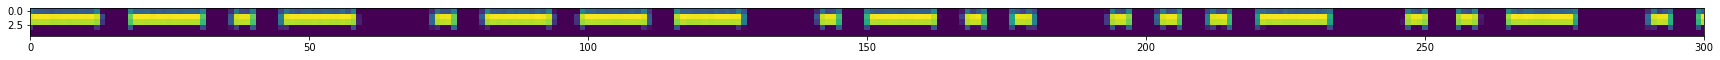

In [155]:
show_image(img_noise_rescaled)

Regression prediction to obtain first letter end position

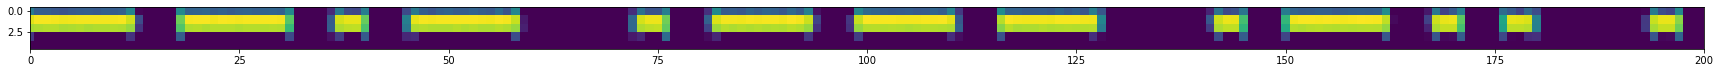

64.22407433390617

In [156]:
first_letter_position = model_regression(expand_image_dims(img_noise_rescaled)).numpy()[0][0] * 1400
show_image(img_noise_rescaled, width=200)
first_letter_position = first_letter_position + NODGE_IMAGE_PIXEL_AMOUNT
first_letter_position

Prepare image for categorical prediction

In [157]:
start_position = int(CATEGORICAL_IMAGE_CROPPED_WIDTH - first_letter_position)
image_with_categorical_cropped = insert_image(
    empty_image=np.zeros(TRAINING_IMAGE_DIMENSIONS), 
    image=img_noise_rescaled[:,:int(first_letter_position)], 
    start_pos=start_position, 
    end_pos= int(first_letter_position) + start_position
)

Categorical prediction

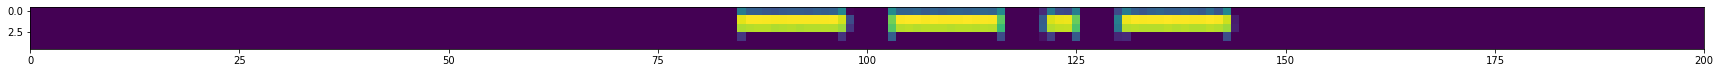

categorical prediction:  16


In [158]:

categorical_prediction = model_categorical(expand_image_dims(image_with_categorical_cropped))
show_image(image_with_categorical_cropped, width=200)
print('categorical prediction: ', np.argmax(categorical_prediction))
